# Combining Neural Networks and Reinforcement learning. 
1. Use deep neural networks to estimate the q values to each state/Action pair. Input - State and Output - q(s,a1),q(s,a2) etc. 
2. Stack of consequetive frames are used as input to the network. 

<img src="dqn1.png"/>


Experience replay: 
we store the agents experience in a dataset called replay memory. We use these replay memory samples to train the network. 
using the sequential data to train the network will lead to an ineffiecient network.  

<img src="dqn2.png"/>

Loss calculation in the network: 
Loss is calculated between the result of the network(estimated q value) and the actual bellman equation. 

 


1. Initialize replay memory capacity. 
2. Initialize the network with random weights. 
3. Clone the policy network and call it Target network. 
4. For each episode: 
    1. Initialie the starting state:
        - via exploration-exploitation strategy. 
    2. Execute selected action on emulator. 
    3. Observe reward and next state. 
    4. Store experience in replay memory. 
    5. Sample random batch from replay memory. 
    6. Preprocess states from batch. -- DONT UNDERSTAND  
    7. Pass batch of preprocessed states to policy network. 
    8. Calculate loss between output Q-values and target Q-values:
        - Require a pass to the target network for the next state. 
    9. Gradient descent updates weights in the policy network to minimize loss:
        - After x time steps, weights in the target network are updated using the weights in the policy network. 
 

# Import Libraries/packages

In [19]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [5]:
# Setup display
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Deep Q-Network

In [6]:
# Deep Q-Network

class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t
                   

# Experience Class

In [9]:
#Experience class

Experience = namedtuple('Experience', ('state','action,'next_state','reward'))

SyntaxError: invalid syntax (<ipython-input-9-163cd520d4fa>, line 3)

# Replay Memory

In [10]:
# Replay memory

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

# Epsilon-Greedy Strategy

In [11]:
# Epsilon Greedy strategy

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

# Reinforcement Learning Agent 

In [14]:
#Reinforcement learning agent

class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device) # explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) # exploit

# Environment Manager

In [16]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done,_ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else: 
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) # 
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        #strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self, screen):
        # convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        #Use torchvision package to compose image transforms 
        resize = T.Compose([T.ToPILImage(), T.Resize(40,90), T.ToTensor()])
        
        return resize(screen).unsqueeze(0).to(self.device)
        
        
        
        
    

# Plot Function

In [20]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg_numpy()

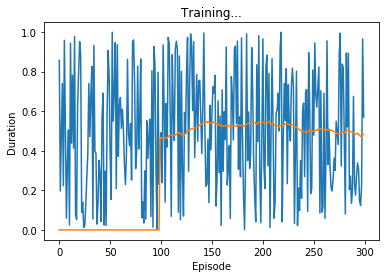

In [21]:
plot(np.random.rand(300), 100)

# MAIN PROGRAM

In [ ]:
batch_size = 256
gamma = 0.999 # Bellman equation
eps_start = 1 # Exploration rate
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # update the target network weights with the policy network weights. 
memory_size = 100000
lr = 0.001 # Policy network learning rate. 
num_episodes = 1000

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_szie)

policy_net = DQN(em.get_screen_height(), em.get_screen_width().to(device))
target_net = DQN(em.get_screen_height(), em.get_screen_width().to(device))
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

